第三章作业主要是学会处理神经网络的过拟合：
- 引入正则化来缓解过拟合：用``tf.nn.l2_loss()``计算模型参数的L2范数，加入到loss中，具体如下：

``` python
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + lmbda * (tf.nn.l2_loss(weights[0]) + tf.nn.l2_loss(weights[1])) # ==> add regularization

# Optimizer.
optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
```
- 用较大的minibatch样本数缓解过拟合：在用较小的minbatch样本训练会出现过拟合，即验证集达到100%准确率，但测试集准确率不高

- 引入dropout来缓解过拟合：用``tf.nn.dropout(keep_prob)``在神经网络的训练中引入dropout，指定keep_prob，具体如下：

``` python
# tf.nn.dropout(x, keep_prob, noise_shape=None, seed=None, name=None)用法
# 参数：训练样本x，keep_prob为训练时神经元节点保留概率

hidden_layer = tf.nn.dropout(hidden_layer, keep_prob)
```

- 用衰减学习率+多层神经网络改善模型性能：
    - 学习率使用指数衰减，前期使用较大学习率来加快得到最优解，越往后epoch使用越小的学习率，避免靠近最优点时出现震荡，更好寻优；
    - 引入多层神经网络，加两层ReLU，将上一层的ReLU输出再进行一次加权组合，W1(feature*hidden_nodes_1)，W2(hidden_nodes_1, hidden_nodes_2), W3(hidden_nodes_2, hidden_nodes_3), 和W4(hidden_nodes_3, num_labels)。

``` python
# tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate, staircase=False, name=None)用法
# 参数：初始值learning_rate, global_step, decay_steps, 衰减率decay_rate, staircase=False
# decayed_learning_rate = learning_rate *
#                        decay_rate ^ (global_step / decay_steps)
# (staircase置True时，global_step/decay_steps为整除)
# 每过一次decay_steps轮，衰减率乘一次decay_rate实现衰减

global_step = tf.Variable(0)  # count the number of steps taken.
learning_rate = tf.train.exponential_decay(0.5, global_step, 500, 0.6, staircase=True) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
```

``` python
def computation(dataset, weights, biases, is_dropout=False): 
    weight_sum_1 = tf.matmul(dataset, weights[0])+ biases[0]
    hidden_layer_1 = tf.nn.relu(weight_sum_1)
    if is_dropout:
        hidden_layer_1 = tf.nn.dropout(hidden_layer_1, keep_prob=0.7)
    weight_sum_2 = tf.matmul(hidden_layer_1, weights[1]) + biases[1]
    hidden_layer_2 = tf.nn.relu(weight_sum_2)
    if is_dropout:
        hidden_layer_2 = tf.nn.dropout(hidden_layer_2, keep_prob=0.7)
    weight_sum_3 = tf.matmul(hidden_layer_2, weights[2]) + biases[2]
    hidden_layer_3 = tf.nn.relu(weight_sum_3)
    if is_dropout:
        hidden_layer_3 = tf.nn.dropout(hidden_layer_3, keep_prob=0.7)
    outputs = tf.matmul(hidden_layer_3, weights[3]) + biases[3]
    return outputs
```

Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

## Linear Regression with Regularization

In [38]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    # ==> define parameter of regularization
    lmbda = tf.placeholder(tf.float32)
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + lmbda * tf.nn.l2_loss(weights)
    # ==> add regularized item
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [41]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, lmbda : 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 19.376085
Minibatch accuracy: 3.9%
Validation accuracy: 13.8%
Minibatch loss at step 500: 2.657836
Minibatch accuracy: 77.3%
Validation accuracy: 76.4%
Minibatch loss at step 1000: 1.627377
Minibatch accuracy: 79.7%
Validation accuracy: 78.4%
Minibatch loss at step 1500: 1.153279
Minibatch accuracy: 78.9%
Validation accuracy: 80.0%
Minibatch loss at step 2000: 0.969894
Minibatch accuracy: 79.7%
Validation accuracy: 80.5%
Minibatch loss at step 2500: 0.691905
Minibatch accuracy: 86.7%
Validation accuracy: 81.0%
Minibatch loss at step 3000: 0.581506
Minibatch accuracy: 86.7%
Validation accuracy: 82.1%
Test accuracy: 89.0%


## Validate the Impact of Lambda 

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

Regularized coefficients: 0.0001
Regularized coefficients: 0.000125892541179
Regularized coefficients: 0.000158489319246
Regularized coefficients: 0.000199526231497
Regularized coefficients: 0.000251188643151
Regularized coefficients: 0.000316227766017
Regularized coefficients: 0.000398107170553
Regularized coefficients: 0.000501187233627
Regularized coefficients: 0.00063095734448
Regularized coefficients: 0.000794328234724
Regularized coefficients: 0.001
Regularized coefficients: 0.00125892541179
Regularized coefficients: 0.00158489319246
Regularized coefficients: 0.00199526231497
Regularized coefficients: 0.00251188643151
Regularized coefficients: 0.00316227766017
Regularized coefficients: 0.00398107170553
Regularized coefficients: 0.00501187233627
Regularized coefficients: 0.0063095734448
Regularized coefficients: 0.00794328234724


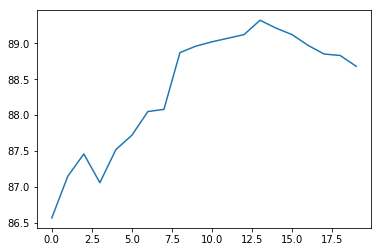

In [44]:
num_steps = 3001
all_lmbda = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
all_accuracy = []
for lmbda_val in all_lmbda:
    print("Regularized coefficients: {}".format(lmbda_val))
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]

            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, lmbda : lmbda_val}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        all_accuracy.append(accuracy(test_prediction.eval(), test_labels))
plt.plot(all_accuracy)
plt.title("Accuracy over Regularizer Coefficient")

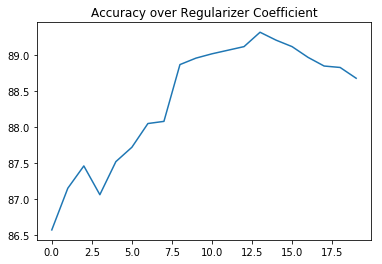

In [45]:
plt.plot(all_accuracy)
plt.title("Accuracy over Regularizer Coefficient")

## Neural Network (1-layer ReLU) with Regularization

In [64]:
hidden_nodes = 1024
batch_size = 128

def computation(dataset, weights, biases):
    weight_sum = tf.add(tf.matmul(dataset, weights[0]), biases[0])
    hidden_layer = tf.nn.relu(weight_sum)
    logits = tf.add(tf.matmul(hidden_layer, weights[1]), biases[1])
    return logits

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    lmbda = tf.placeholder(tf.float32) # ==> add placeholder
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = [tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes])), 
             tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
            ]
    biases = [tf.Variable(tf.zeros([hidden_nodes])),
            tf.Variable(tf.zeros([num_labels]))]

    # Training computation.
    logits = computation(tf_train_dataset, weights, biases)
    
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + lmbda * (tf.nn.l2_loss(weights[0]) + tf.nn.l2_loss(weights[1])) # ==> add regularization

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(computation(tf_valid_dataset, weights, biases))
    test_prediction = tf.nn.softmax(computation(tf_test_dataset, weights, biases))

In [65]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):

        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, lmbda : 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 617.020447
Minibatch accuracy: 14.1%
Validation accuracy: 34.7%
Minibatch loss at step 500: 206.956284
Minibatch accuracy: 72.7%
Validation accuracy: 77.8%
Minibatch loss at step 1000: 113.745140
Minibatch accuracy: 85.2%
Validation accuracy: 81.3%
Minibatch loss at step 1500: 68.286926
Minibatch accuracy: 81.2%
Validation accuracy: 82.7%
Minibatch loss at step 2000: 41.318298
Minibatch accuracy: 85.9%
Validation accuracy: 84.4%
Minibatch loss at step 2500: 25.188065
Minibatch accuracy: 91.4%
Validation accuracy: 85.7%
Minibatch loss at step 3000: 15.299156
Minibatch accuracy: 93.8%
Validation accuracy: 86.6%
Test accuracy: 93.3%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [50]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = ((step % 10) * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, lmbda : 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 21.644571
Minibatch accuracy: 7.0%
Validation accuracy: 13.5%
Minibatch loss at step 500: 1.961034
Minibatch accuracy: 96.9%
Validation accuracy: 70.4%
Minibatch loss at step 1000: 1.173835
Minibatch accuracy: 99.2%
Validation accuracy: 72.0%
Minibatch loss at step 1500: 0.738649
Minibatch accuracy: 99.2%
Validation accuracy: 73.4%
Minibatch loss at step 2000: 0.498035
Minibatch accuracy: 99.2%
Validation accuracy: 74.6%
Minibatch loss at step 2500: 0.356002
Minibatch accuracy: 100.0%
Validation accuracy: 75.4%
Minibatch loss at step 3000: 0.271700
Minibatch accuracy: 100.0%
Validation accuracy: 75.8%
Test accuracy: 84.4%


**结论：**计算minibatch的offet时，修改为``offset = ((step % 10) * batch_size) % (train_labels.shape[0] - batch_size)``，限制反复使用相同的10个batch数据（每个batch有128个样本），每次epoch使用一个batch。可以看到在2500次迭代后，minibatch的数据可以达到100%准确率，但在测试集上只有84.4%，远不如之前的93.3%

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [62]:
hidden_nodes = 1024
batch_size = 128

def computation(dataset, weights, biases, is_dropout=False, keep_prob=0.5):
    weight_sum = tf.add(tf.matmul(dataset, weights[0]), biases[0])
    hidden_layer = tf.nn.relu(weight_sum)
    if is_dropout: # ==> add dropout
        hidden_layer = tf.nn.dropout(hidden_layer, keep_prob)
    logits = tf.add(tf.matmul(hidden_layer, weights[1]), biases[1])
    return logits

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    lmbda = tf.placeholder(tf.float32) # ==> add placeholder
    keep_prob = tf.placeholder(tf.float32) # ==> add placeholder
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = [tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes])), 
             tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))]
    biases = [tf.Variable(tf.zeros([hidden_nodes])),
            tf.Variable(tf.zeros([num_labels]))]

    # Training computation.
    logits = computation(tf_train_dataset, weights, biases, is_dropout=True, keep_prob=keep_prob)
    
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + lmbda * (tf.nn.l2_loss(weights[0]) + tf.nn.l2_loss(weights[1])) # ==> add regularization

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(computation(tf_valid_dataset, weights, biases))
    test_prediction = tf.nn.softmax(computation(tf_test_dataset, weights, biases))

In [63]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, lmbda : 1e-3, keep_prob : 0.7}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 746.116699
Minibatch accuracy: 11.7%
Validation accuracy: 32.7%
Minibatch loss at step 500: 200.717834
Minibatch accuracy: 75.0%
Validation accuracy: 78.4%
Minibatch loss at step 1000: 114.825737
Minibatch accuracy: 80.5%
Validation accuracy: 80.8%
Minibatch loss at step 1500: 68.643456
Minibatch accuracy: 79.7%
Validation accuracy: 82.9%
Minibatch loss at step 2000: 41.425804
Minibatch accuracy: 82.0%
Validation accuracy: 83.5%
Minibatch loss at step 2500: 25.150757
Minibatch accuracy: 86.7%
Validation accuracy: 85.3%
Minibatch loss at step 3000: 15.244875
Minibatch accuracy: 92.2%
Validation accuracy: 86.2%
Test accuracy: 92.7%


**结论：**只在训练中加入dropout操作，验证和测试时不加入。随机丢弃一部分神经元，以一定概率使得神经元激活函数不参与。貌似只能解决小minibatch的过拟合问题，对于大minibatch时，加入dropout效果迭代3000次得到（92.7%）并不如不加的（93.3%）。

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [113]:
hidden_nodes_1 = 1024
hidden_nodes_2 = 500
hidden_nodes_3 = 100
batch_size = 128

def computation(dataset, weights, biases, is_dropout=False): 
    weight_sum_1 = tf.matmul(dataset, weights[0])+ biases[0]
    hidden_layer_1 = tf.nn.relu(weight_sum_1)
    if is_dropout:
        hidden_layer_1 = tf.nn.dropout(hidden_layer_1, keep_prob=0.7)
    weight_sum_2 = tf.matmul(hidden_layer_1, weights[1]) + biases[1]
    hidden_layer_2 = tf.nn.relu(weight_sum_2)
    if is_dropout:
        hidden_layer_2 = tf.nn.dropout(hidden_layer_2, keep_prob=0.7)
    weight_sum_3 = tf.matmul(hidden_layer_2, weights[2]) + biases[2]
    hidden_layer_3 = tf.nn.relu(weight_sum_3)
    if is_dropout:
        hidden_layer_3 = tf.nn.dropout(hidden_layer_3, keep_prob=0.7)
    outputs = tf.matmul(hidden_layer_3, weights[3]) + biases[3]
    return outputs

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    lmbda = tf.placeholder(tf.float32) # ==> add placeholder
#     keep_prob = tf.placeholder(tf.float32) # ==> add placeholder
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    global_step = tf.Variable(0) # ==> Add for learning rate decay
    
    # Variables.
    weights = [tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes_1],
                                stddev=np.sqrt(2.0 / (image_size * image_size)))), 
            tf.Variable(tf.truncated_normal([hidden_nodes_1, hidden_nodes_2],
                                stddev=np.sqrt(2.0 / hidden_nodes_1))),
            tf.Variable(tf.truncated_normal([hidden_nodes_2, hidden_nodes_3],
                                stddev=np.sqrt(2.0 / hidden_nodes_2))),
            tf.Variable(tf.truncated_normal([hidden_nodes_3, num_labels],
                                stddev=np.sqrt(2.0 / hidden_nodes_3)))
               
              ]

    biases = [tf.Variable(tf.zeros([hidden_nodes_1])),
            tf.Variable(tf.zeros([hidden_nodes_2])),
            tf.Variable(tf.zeros([hidden_nodes_3])),
            tf.Variable(tf.zeros([num_labels]))
             ]

    # Training computation.
    logits = computation(tf_train_dataset, weights, biases, is_dropout=True) 
    
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) \
        + lmbda * (tf.nn.l2_loss(weights[0]) \
        + tf.nn.l2_loss(weights[1]) \
        + tf.nn.l2_loss(weights[2]) \
        + tf.nn.l2_loss(weights[3])) # ==> add regularization

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 500, 0.9)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
#     optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(computation(tf_valid_dataset, weights, biases))
    test_prediction = tf.nn.softmax(computation(tf_test_dataset, weights, biases))

In [115]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

num_steps = 8001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, lmbda : 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.903420
Minibatch accuracy: 8.6%
Validation accuracy: 31.9%
Minibatch loss at step 500: 1.387359
Minibatch accuracy: 84.4%
Validation accuracy: 84.9%
Minibatch loss at step 1000: 0.973619
Minibatch accuracy: 88.3%
Validation accuracy: 86.1%
Minibatch loss at step 1500: 0.967071
Minibatch accuracy: 84.4%
Validation accuracy: 86.5%
Minibatch loss at step 2000: 0.897126
Minibatch accuracy: 82.8%
Validation accuracy: 87.2%
Minibatch loss at step 2500: 0.560037
Minibatch accuracy: 91.4%
Validation accuracy: 87.5%
Minibatch loss at step 3000: 0.477757
Minibatch accuracy: 93.8%
Validation accuracy: 88.1%
Minibatch loss at step 3500: 0.596783
Minibatch accuracy: 86.7%
Validation accuracy: 88.2%
Minibatch loss at step 4000: 0.578859
Minibatch accuracy: 89.8%
Validation accuracy: 88.5%
Minibatch loss at step 4500: 0.515870
Minibatch accuracy: 89.1%
Validation accuracy: 88.8%
Minibatch loss at step 5000: 0.603967
Minibatch accuracy: 85.2%
Validation accuracy